# Train Stacking

In [1]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        # Currently, there's no separate manual seed function for MPS like torch.cuda.manual_seed_all()
        pass 
    else:
        print("MPS device not available. Using CPU.")
        
set_seed()

Best F1 score BERT model on HS_C dataset are used

In [2]:
# This automates data tabulation onto google sheets 

import gspread
from oauth2client.service_account import ServiceAccountCredentials
from googleapiclient.discovery import build

import os

# new directory path
new_directory = '/Users/levan/ATENEO MASTERAL/Thesis'

# Change the current working directory
os.chdir(new_directory)

# Use creds to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('thesis-432315-12daec8d1ff6.json', scope)

service = build('sheets', 'v4', credentials=creds)

client = gspread.authorize(creds)

spreadsheet_id = '1wKr9B0W-j7C-38o-DoQY_ldR7Leroua-RaDHG3Mbkf0' 

## Load Dataset

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AutoConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


import os

# new directory path
new_directory = '/Users/levan/ATENEO MASTERAL/Thesis/Development'

# Change the current working directory
os.chdir(new_directory)

#Load Data
df = pd.read_csv('Corpus/data_b.csv')
X = df['text'].values
y = df['label'].values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)



## Load Models and Tokenizers

In [4]:
def load_model_and_tokenizer(model_path, tokenizer_path, base_model):
    # Load the tokenizer from the local directory
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    
    # Load the configuration from the base model, then update configuration if needed
    config = AutoConfig.from_pretrained(base_model, num_labels=2)

    # Initialize the model with the configuration
    model = AutoModelForSequenceClassification.from_pretrained(model_path, config=config)

    # Ensure the model is in evaluation mode
    model.eval()
    
    return model, tokenizer

model_info = {
    
    'BERT cased': {
        'model_path': 'BERT models/hs_bert-base-cased-finetuned',
        'tokenizer_path': 'BERT models/hs_bert-base-cased-finetuned',
        'base_model': 'google-bert/bert-base-cased'
    },

    'DistilBERT uncased': {
        'model_path': 'BERT models/hs_distilbert-base-uncased-finetuned',
        'tokenizer_path': 'BERT models/hs_distilbert-base-uncased-finetuned',
        'base_model': 'distilbert/distilbert-base-uncased'
    },

    'DeBERTa': {
        'model_path': 'BERT models/hs_DeBERTa-finetuned',
        'tokenizer_path': 'BERT models/hs_DeBERTa-finetuned',
        'base_model': 'microsoft/deberta-v3-base'
    },
    
    'BERT uncased': {
        'model_path': 'BERT models/hs_bert-base-uncased-finetuned',
        'tokenizer_path': 'BERT models/hs_bert-base-uncased-finetuned',
        'base_model': 'google-bert/bert-base-uncased'
    },
}


models_and_tokenizers = {name: load_model_and_tokenizer(info['model_path'], 
                                                        info['tokenizer_path'], 
                                                        info['base_model']) 
                         for name, info in model_info.items()}


## Apply Tokenization

In [5]:
class MultiModelTextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, models_and_tokenizers, max_len):
        self.texts = texts
        self.labels = labels
        self.models_and_tokenizers = models_and_tokenizers
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        label = self.labels[index]

        model_inputs = {}
        for name, (model, tokenizer) in self.models_and_tokenizers.items():
            encoding = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=self.max_len,
                return_token_type_ids=False,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt',
            )
            model_inputs[name] = {
                'input_ids': encoding['input_ids'].squeeze(0),  # Remove batch dimension
                'attention_mask': encoding['attention_mask'].squeeze(0)  # Remove batch dimension
            }
        return {'model_inputs': model_inputs, 'label': torch.tensor(label, dtype=torch.long)}


## BERT Training for Stacking

In [6]:
def train_base_learner(model, data_loader, optimizer, device):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = model.to(device)
    model.train()
    correct_predictions = 0
    losses = []

    for batch in data_loader:
        # Accessing inputs for the current model
        inputs = batch['model_inputs']
        labels = batch['label'].to(device)

        for model_name, model_inputs in inputs.items():
            # Forward pass
            outputs = model(input_ids=model_inputs['input_ids'].squeeze(1).to(device),
                attention_mask=model_inputs['attention_mask'].squeeze(1).to(device),
                labels=labels)

            loss = outputs.loss
            preds = outputs.logits.argmax(dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    return correct_predictions.float() / len(data_loader.dataset), np.mean(losses).astype(np.float32)




def eval_model(model, data_loader, device):
    model = model.eval()
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = outputs.logits.argmax(dim=1)
            correct_predictions += torch.sum(preds == labels)

    return correct_predictions.double() / len(data_loader.dataset)


## Train Stacking

In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from torch.utils.data import DataLoader
from transformers import AdamW

def train_stacking_classifier(models_and_tokenizers, X_train, y_train, device, max_len=128):
    n_splits = 4
    skf = StratifiedKFold(n_splits=n_splits)
    base_learners_predictions_train = np.zeros((len(X_train), len(models_and_tokenizers)))
    fold_idx = 0

    for train_idx, val_idx in skf.split(X_train, y_train):
        fold_idx += 1
        print(f"Training fold {fold_idx}/{n_splits}...")
        train_texts, val_texts = X_train[train_idx], X_train[val_idx]
        train_labels, val_labels = y_train[train_idx], y_train[val_idx]
        
        model_idx = 0
        for name, info in model_info.items():
            # Reload the model and tokenizer to reset weights
            model, tokenizer = load_model_and_tokenizer(info['model_path'], info['tokenizer_path'], info['base_model'])
            model.to(device)
            
            train_dataset = MultiModelTextDataset(train_texts, train_labels, {name: (model, tokenizer)}, max_len)
            val_dataset = MultiModelTextDataset(val_texts, val_labels, {name: (model, tokenizer)}, max_len)
            train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
            
            optimizer = AdamW(model.parameters(), lr=5e-5)
            train_base_learner(model, train_loader, optimizer, device)
            
            val_preds = []
            model.eval()
            for batch in val_loader:
                inputs = batch['model_inputs'][name]
                with torch.no_grad():
                    outputs = model(input_ids=inputs['input_ids'].to(device), attention_mask=inputs['attention_mask'].to(device))
                val_preds.extend(outputs.logits.argmax(dim=1).cpu().numpy())
            
            base_learners_predictions_train[val_idx, model_idx] = np.array(val_preds)
            model_idx += 1

    return base_learners_predictions_train, y_train
    

def get_predictions(model_info, X, y, device, max_len=128):
    predictions = np.zeros((len(X), len(model_info)))
    model_idx = 0
    for name, info in model_info.items():
        # Reload the model and tokenizer
        model, tokenizer = load_model_and_tokenizer(info['model_path'], info['tokenizer_path'], info['base_model'])
        model.to(device)
        model.eval()
        
        dataset = MultiModelTextDataset(X, y, {name: (model, tokenizer)}, max_len)
        loader = DataLoader(dataset, batch_size=16, shuffle=False)
        
        preds = []
        for batch in loader:
            inputs = batch['model_inputs'][name]
            with torch.no_grad():
                outputs = model(input_ids=inputs['input_ids'].to(device), attention_mask=inputs['attention_mask'].to(device))
            preds.extend(outputs.logits.argmax(dim=1).cpu().numpy())
        
        predictions[:, model_idx] = np.array(preds)
        model_idx += 1

    return predictions


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

## Perform Stacking

In [8]:
%load_ext memory_profiler

In [9]:
%%memit

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Train stacking classifier (using 4-fold cross validation for each BERT model) on Train Set and retrieve training meta-features
train_meta_features, _ = train_stacking_classifier(model_info, X_train, y_train, device)

# Generate predictions for the test set to be used as test meta-features
test_meta_features = get_predictions(model_info, X_test, y_test, device)

Training fold 1/4...


/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training fold 2/4...
Training fold 3/4...
Training fold 4/4...
peak memory: 2938.48 MiB, increment: 584.91 MiB


### Train LR

In [10]:
%%memit

lr_meta_classifier = LogisticRegression()
lr_meta_classifier.fit(train_meta_features, y_train)

lr_final_predictions = lr_meta_classifier.predict(test_meta_features)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 1202.97 MiB, increment: 2.42 MiB


### Train NB

In [11]:
%%memit

nb_meta_classifier = GaussianNB()
nb_meta_classifier.fit(train_meta_features, y_train)

nb_final_predictions = nb_meta_classifier.predict(test_meta_features)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

peak memory: 1203.73 MiB, increment: 0.73 MiB


### Train DT

In [12]:
%%memit

dt_meta_classifier = DecisionTreeClassifier(max_depth=None)
dt_meta_classifier.fit(train_meta_features, y_train)

dt_final_predictions = dt_meta_classifier.predict(test_meta_features)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

peak memory: 1204.89 MiB, increment: 1.14 MiB


### Train SVM

In [13]:
%%memit

svm_meta_classifier = SVC(kernel='linear', probability=True)
svm_meta_classifier.fit(train_meta_features, y_train)

svm_final_predictions = svm_meta_classifier.predict(test_meta_features)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 1243.17 MiB, increment: 38.27 MiB


## EVALUATE MODELS

### LR

In [14]:
# Evaluate
precision = precision_score(y_test, lr_final_predictions, average='binary')
recall = recall_score(y_test, lr_final_predictions, average='binary')
accuracy = accuracy_score(y_test, lr_final_predictions)
f1 = f1_score(y_test, lr_final_predictions, average='binary')
conf_matrix = confusion_matrix(y_test, lr_final_predictions)

print("Logistic Regression")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Ensemble accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)


Logistic Regression
Precision: 0.7438735177865613
Recall: 0.8105081826012058
Ensemble accuracy: 0.7817890092258323
F1 Score: 0.7757625721352019
Confusion Matrix:
[[1008  324]
 [ 220  941]]


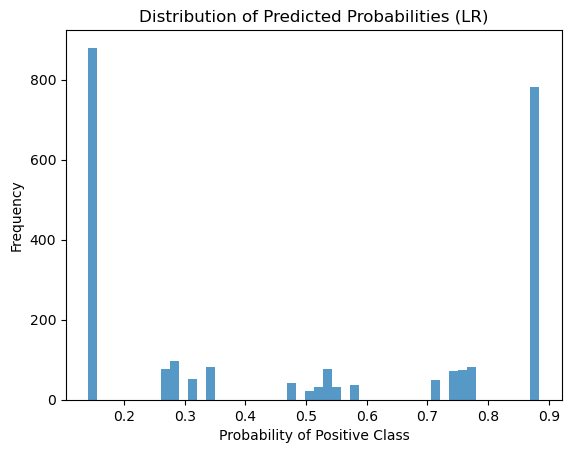

In [15]:
# Get probability scores for threshold optimization
lr_prob_scores = lr_meta_classifier.predict_proba(test_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(lr_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (LR)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()


In [16]:
# Threshold optimization
thresholds = np.linspace(0.01, 0.99, 99)
scores = [f1_score(y_test, lr_prob_scores >= t, average='binary') for t in thresholds]
best_thresh = thresholds[np.argmax(scores)]
adjusted_predictions = (lr_prob_scores >= best_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(y_test, adjusted_predictions, average='binary')
adjusted_recall = recall_score(y_test, adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(y_test, adjusted_predictions)
adjusted_f1 = f1_score(y_test, adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(y_test, adjusted_predictions)

print(f"Adjusted threshold: {best_thresh}")
print("Optimized Logistic Regression")
print(f"Precision: {adjusted_precision}")
print(f"Recall: {adjusted_recall}")
print(f"Accuracy: {adjusted_accuracy}")
print(f"F1 Score: {adjusted_f1}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

lr_thresh = best_thresh

Adjusted threshold: 0.32
Optimized Logistic Regression
Precision: 0.7139769452449568
Recall: 0.8535745047372955
Accuracy: 0.7725631768953068
F1 Score: 0.7775598273832875
Confusion Matrix:
[[935 397]
 [170 991]]


In [17]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '4-1!B4:E4'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


### NB

In [18]:
# Evaluate
precision = precision_score(y_test, nb_final_predictions, average='binary')
recall = recall_score(y_test, nb_final_predictions, average='binary')
accuracy = accuracy_score(y_test, nb_final_predictions)
f1 = f1_score(y_test, nb_final_predictions, average='binary')
conf_matrix = confusion_matrix(y_test, nb_final_predictions)

print("Naive Bayes")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Ensemble accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)


Naive Bayes
Precision: 0.730680948737567
Recall: 0.8225667527993109
Ensemble accuracy: 0.776173285198556
F1 Score: 0.7739059967585089
Confusion Matrix:
[[980 352]
 [206 955]]


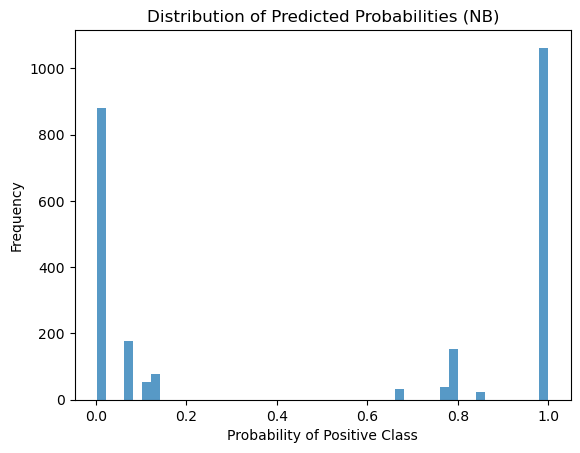

In [19]:
# Get probability scores for threshold optimization
nb_prob_scores = nb_meta_classifier.predict_proba(test_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(nb_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (NB)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()


In [20]:
# Threshold optimization
thresholds = np.linspace(0.01, 0.99, 99)
scores = [f1_score(y_test, nb_prob_scores >= t, average='binary') for t in thresholds]
best_thresh = thresholds[np.argmax(scores)]
adjusted_predictions = (nb_prob_scores >= best_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(y_test, adjusted_predictions, average='binary')
adjusted_recall = recall_score(y_test, adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(y_test, adjusted_predictions)
adjusted_f1 = f1_score(y_test, adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(y_test, adjusted_predictions)

print(f"Adjusted threshold: {best_thresh}")
print("Optimized Naive Bayes")
print(f"Precision: {adjusted_precision}")
print(f"Recall: {adjusted_recall}")
print(f"Accuracy: {adjusted_accuracy}")
print(f"F1 Score: {adjusted_f1}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

nb_thresh = best_thresh

Adjusted threshold: 0.13
Optimized Naive Bayes
Precision: 0.730680948737567
Recall: 0.8225667527993109
Accuracy: 0.776173285198556
F1 Score: 0.7739059967585089
Confusion Matrix:
[[980 352]
 [206 955]]


In [21]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '4-1!B5:E5'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


### DT

In [22]:
# Evaluate
precision = precision_score(y_test, dt_final_predictions, average='binary')
recall = recall_score(y_test, dt_final_predictions, average='binary')
accuracy = accuracy_score(y_test, dt_final_predictions)
f1 = f1_score(y_test, dt_final_predictions, average='binary')
conf_matrix = confusion_matrix(y_test, dt_final_predictions)

print("Decision Tree")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Ensemble accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)


Decision Tree
Precision: 0.7719756309834639
Recall: 0.7639965546942291
Ensemble accuracy: 0.784997994384276
F1 Score: 0.767965367965368
Confusion Matrix:
[[1070  262]
 [ 274  887]]


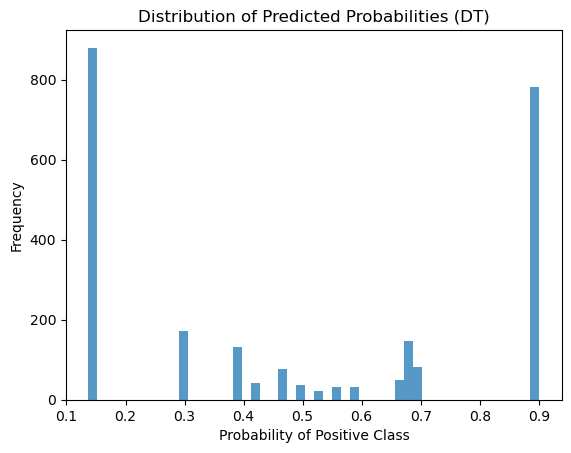

In [23]:
# Get probability scores for threshold optimization
dt_prob_scores = dt_meta_classifier.predict_proba(test_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(dt_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (DT)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()


In [24]:
# Threshold optimization
thresholds = np.linspace(0.01, 0.99, 99)
scores = [f1_score(y_test, dt_prob_scores >= t, average='binary') for t in thresholds]
best_thresh = thresholds[np.argmax(scores)]
adjusted_predictions = (dt_prob_scores >= best_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(y_test, adjusted_predictions, average='binary')
adjusted_recall = recall_score(y_test, adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(y_test, adjusted_predictions)
adjusted_f1 = f1_score(y_test, adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(y_test, adjusted_predictions)

print(f"Adjusted threshold: {best_thresh}")
print("Optimized Decision Tree")
print(f"Precision: {adjusted_precision}")
print(f"Recall: {adjusted_recall}")
print(f"Accuracy: {adjusted_accuracy}")
print(f"F1 Score: {adjusted_f1}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

dt_thresh = best_thresh

Adjusted threshold: 0.3
Optimized Decision Tree
Precision: 0.7006944444444444
Recall: 0.8690783807062877
Accuracy: 0.7661452065784196
F1 Score: 0.7758554402153018
Confusion Matrix:
[[ 901  431]
 [ 152 1009]]


In [25]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '4-1!B6:E6'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


### SVM

In [26]:
# Evaluate
precision = precision_score(y_test, svm_final_predictions, average='binary')
recall = recall_score(y_test, svm_final_predictions, average='binary')
accuracy = accuracy_score(y_test, svm_final_predictions)
f1 = f1_score(y_test, svm_final_predictions, average='binary')
conf_matrix = confusion_matrix(y_test, svm_final_predictions)

print("SVM")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Ensemble accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)


SVM
Precision: 0.766107678729038
Recall: 0.7476313522825151
Ensemble accuracy: 0.776173285198556
F1 Score: 0.7567567567567568
Confusion Matrix:
[[1067  265]
 [ 293  868]]


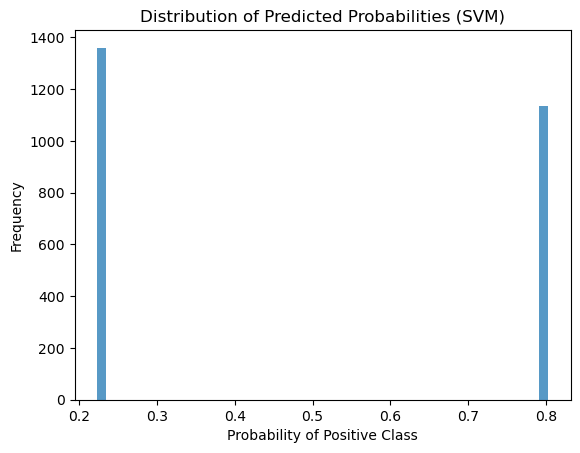

In [27]:
# Get probability scores for threshold optimization
svm_prob_scores = svm_meta_classifier.predict_proba(test_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(svm_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (SVM)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()


In [28]:
# Threshold optimization
thresholds = np.linspace(0.01, 0.99, 99)
scores = [f1_score(y_test, svm_prob_scores >= t, average='binary') for t in thresholds]
best_thresh = thresholds[np.argmax(scores)]
adjusted_predictions = (svm_prob_scores >= best_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(y_test, adjusted_predictions, average='binary')
adjusted_recall = recall_score(y_test, adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(y_test, adjusted_predictions)
adjusted_f1 = f1_score(y_test, adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(y_test, adjusted_predictions)

print(f"Adjusted threshold: {best_thresh}")
print("Optimized SVM")
print(f"Precision: {adjusted_precision}")
print(f"Recall: {adjusted_recall}")
print(f"Accuracy: {adjusted_accuracy}")
print(f"F1 Score: {adjusted_f1}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

svm_thresh = best_thresh

Adjusted threshold: 0.23
Optimized SVM
Precision: 0.766107678729038
Recall: 0.7476313522825151
Accuracy: 0.776173285198556
F1 Score: 0.7567567567567568
Confusion Matrix:
[[1067  265]
 [ 293  868]]


In [29]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '4-1!B7:E7'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


## TEST DATA C

In [30]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load validation data
validation_file_path = 'Corpus/data_c.csv'
validation_df = pd.read_csv(validation_file_path)

X_val = validation_df['text'].values 
y_val = validation_df['label'].values

# Generate meta-features for data c dataset
val_meta_features = get_predictions(model_info, X_val, y_val, device) 

# Predict using the logistic regression meta-classifier
val_lr_predictions = lr_meta_classifier.predict(val_meta_features)

# Predict using the naive bayes meta-classifier
val_nb_predictions = nb_meta_classifier.predict(val_meta_features)

# Predict using the decision tree meta-classifier
val_dt_predictions = dt_meta_classifier.predict(val_meta_features)

# Predict using the svm meta-classifier
val_svm_predictions = svm_meta_classifier.predict(val_meta_features)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

### LR

In [31]:
# Evaluate the predictions
precision = precision_score(y_val, val_lr_predictions, average='binary')
recall = recall_score(y_val, val_lr_predictions, average='binary')
accuracy = accuracy_score(y_val, val_lr_predictions)
f1 = f1_score(y_val, val_lr_predictions, average='binary')
conf_matrix = confusion_matrix(y_val, val_lr_predictions)

print("Evaluation on HS-Data C Dataset")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Evaluation on HS-Data C Dataset
Precision: 0.7536382536382537
Recall: 0.8430232558139535
Accuracy: 0.7985923118570655
F1 Score: 0.7958287596048299
Confusion Matrix:
[[750 237]
 [135 725]]


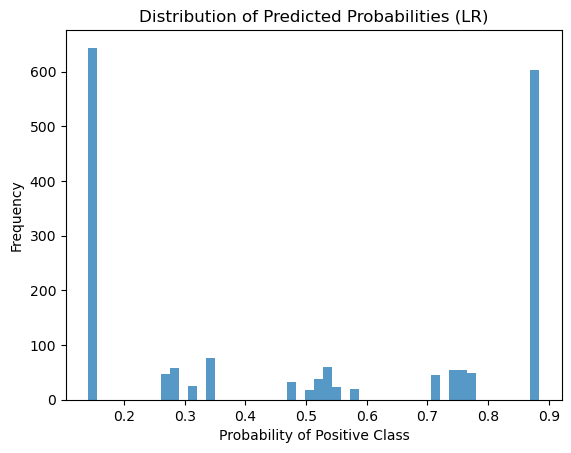

In [32]:
# Get probability scores for threshold optimization
lr_prob_scores = lr_meta_classifier.predict_proba(val_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(lr_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (LR)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()


In [33]:
adjusted_predictions = (lr_prob_scores >= lr_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(y_val, adjusted_predictions, average='binary')
adjusted_recall = recall_score(y_val, adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(y_val, adjusted_predictions)
adjusted_f1 = f1_score(y_val, adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(y_val, adjusted_predictions)

print(f"Adjusted threshold: {lr_thresh}")
print("Optimized Logistic Regression")
print(f"Precision: {adjusted_precision}")
print(f"Recall: {adjusted_recall}")
print(f"Accuracy: {adjusted_accuracy}")
print(f"F1 Score: {adjusted_f1}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

Adjusted threshold: 0.32
Optimized Logistic Regression
Precision: 0.7154850746268657
Recall: 0.891860465116279
Accuracy: 0.7845154304277207
F1 Score: 0.7939958592132506
Confusion Matrix:
[[682 305]
 [ 93 767]]


In [34]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '4-1!F4:I4'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


#### Save CM

In [35]:
import altair as alt
import altair_saver
import pandas as pd
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_val, adjusted_predictions)

# Define class names
class_names = ['Non Hatespeech', 'Hate Speech']

# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names).reset_index().melt(id_vars='index')
cm_df.columns = ['True', 'Predicted', 'Count']

# Ensure the order of categories
cm_df['True'] = pd.Categorical(cm_df['True'], categories=class_names, ordered=True)
cm_df['Predicted'] = pd.Categorical(cm_df['Predicted'], categories=class_names, ordered=True)

# Create the Altair plot
heatmap = alt.Chart(cm_df).mark_rect().encode(
    x=alt.X('Predicted:O', sort=class_names),
    y=alt.Y('True:O', sort=class_names),
    color='Count:Q',
    tooltip=['True', 'Predicted', 'Count']
).properties(
    width=400,
    height=300,
    title='OH_Using_HS 4STK-1 LR'
)

# Add text labels
text = heatmap.mark_text(
    align='center',
    baseline='middle',
    fontSize=12
).encode(
    text='Count:Q',
    color=alt.condition(
        alt.datum.Count > cm.max() / 2,
        alt.value('white'),
        alt.value('black')
    )
)

# Combine heatmap and text
final_chart = heatmap + text

# Display the plot
final_chart.show()

alt.LayerChart(...)

In [36]:
# Specify the folder path
folder_path = os.path.expanduser('Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS Ensemble/Stacking/')

# Save the plot using vl-convert
file_path_png = os.path.join(folder_path, 'OH_Using_HS 4STK-1 LR.png')
final_chart.save(file_path_png)

print(f"Plot saved to {file_path_png}")

Plot saved to Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS Ensemble/Stacking/OH_Using_HS 4STK-1 LR.png


### NB

In [37]:
# Evaluate the predictions
precision = precision_score(y_val, val_nb_predictions, average='binary')
recall = recall_score(y_val, val_nb_predictions, average='binary')
accuracy = accuracy_score(y_val, val_nb_predictions)
f1 = f1_score(y_val, val_nb_predictions, average='binary')
conf_matrix = confusion_matrix(y_val, val_nb_predictions)

print("Evaluation on HS-Data C Dataset")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Evaluation on HS-Data C Dataset
Precision: 0.7447236180904523
Recall: 0.8616279069767442
Accuracy: 0.7980508933405522
F1 Score: 0.798921832884097
Confusion Matrix:
[[733 254]
 [119 741]]


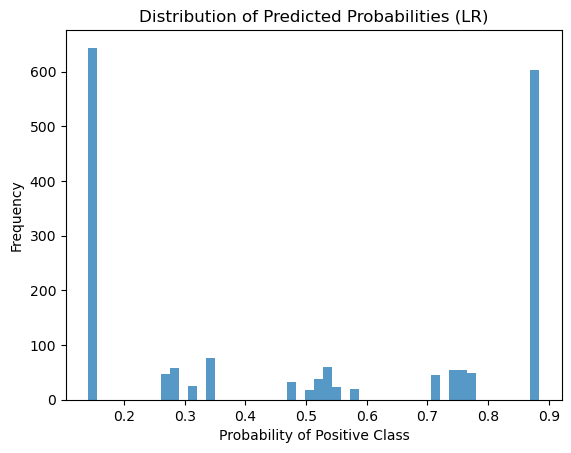

In [38]:
# Get probability scores for threshold optimization
nb_prob_scores = nb_meta_classifier.predict_proba(val_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(lr_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (LR)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()


In [39]:
adjusted_predictions = (nb_prob_scores >= nb_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(y_val, adjusted_predictions, average='binary')
adjusted_recall = recall_score(y_val, adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(y_val, adjusted_predictions)
adjusted_f1 = f1_score(y_val, adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(y_val, adjusted_predictions)

print(f"Adjusted threshold: {nb_thresh}")
print("Optimized Naive Bayes")
print(f"Precision: {adjusted_precision}")
print(f"Recall: {adjusted_recall}")
print(f"Accuracy: {adjusted_accuracy}")
print(f"F1 Score: {adjusted_f1}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

Adjusted threshold: 0.13
Optimized Naive Bayes
Precision: 0.7447236180904523
Recall: 0.8616279069767442
Accuracy: 0.7980508933405522
F1 Score: 0.798921832884097
Confusion Matrix:
[[733 254]
 [119 741]]


In [40]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '4-1!F5:I5'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


#### Save CM

In [41]:
import altair as alt
import altair_saver
import pandas as pd
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_val, adjusted_predictions)

# Define class names
class_names = ['Non Hatespeech', 'Hate Speech']

# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names).reset_index().melt(id_vars='index')
cm_df.columns = ['True', 'Predicted', 'Count']

# Ensure the order of categories
cm_df['True'] = pd.Categorical(cm_df['True'], categories=class_names, ordered=True)
cm_df['Predicted'] = pd.Categorical(cm_df['Predicted'], categories=class_names, ordered=True)

# Create the Altair plot
heatmap = alt.Chart(cm_df).mark_rect().encode(
    x=alt.X('Predicted:O', sort=class_names),
    y=alt.Y('True:O', sort=class_names),
    color='Count:Q',
    tooltip=['True', 'Predicted', 'Count']
).properties(
    width=400,
    height=300,
    title='OH_Using_HS 4STK-1 NB'
)

# Add text labels
text = heatmap.mark_text(
    align='center',
    baseline='middle',
    fontSize=12
).encode(
    text='Count:Q',
    color=alt.condition(
        alt.datum.Count > cm.max() / 2,
        alt.value('white'),
        alt.value('black')
    )
)

# Combine heatmap and text
final_chart = heatmap + text

# Display the plot
final_chart.show()

alt.LayerChart(...)

In [42]:
# Specify the folder path
folder_path = os.path.expanduser('Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS Ensemble/Stacking/')

# Save the plot using vl-convert
file_path_png = os.path.join(folder_path, 'OH_Using_HS 4STK-1 NB.png')
final_chart.save(file_path_png)

print(f"Plot saved to {file_path_png}")

Plot saved to Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS Ensemble/Stacking/OH_Using_HS 4STK-1 NB.png


### DT

In [43]:
# Evaluate the predictions
precision = precision_score(y_val, val_dt_predictions, average='binary')
recall = recall_score(y_val, val_dt_predictions, average='binary')
accuracy = accuracy_score(y_val, val_dt_predictions)
f1 = f1_score(y_val, val_dt_predictions, average='binary')
conf_matrix = confusion_matrix(y_val, val_dt_predictions)

print("Evaluation on HS-Data C Dataset")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Evaluation on HS-Data C Dataset
Precision: 0.7703619909502263
Recall: 0.791860465116279
Accuracy: 0.7931781266919329
F1 Score: 0.7809633027522935
Confusion Matrix:
[[784 203]
 [179 681]]


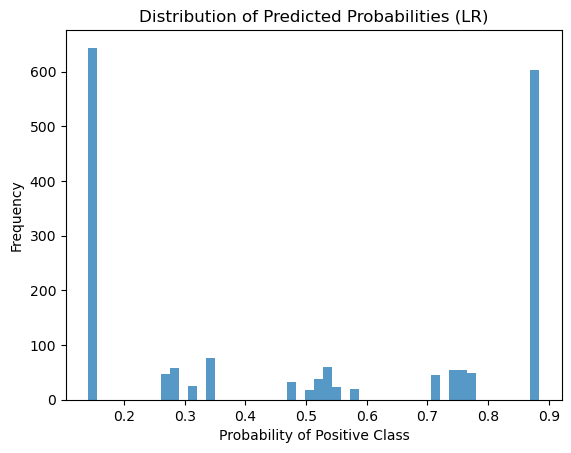

In [44]:
# Get probability scores for threshold optimization
dt_prob_scores = dt_meta_classifier.predict_proba(val_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(lr_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (LR)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()

In [45]:
adjusted_predictions = (dt_prob_scores >= dt_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(y_val, adjusted_predictions, average='binary')
adjusted_recall = recall_score(y_val, adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(y_val, adjusted_predictions)
adjusted_f1 = f1_score(y_val, adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(y_val, adjusted_predictions)

print(f"Adjusted threshold: {dt_thresh}")
print("Optimized Decision Tree")
print(f"Precision: {adjusted_precision}")
print(f"Recall: {adjusted_recall}")
print(f"Accuracy: {adjusted_accuracy}")
print(f"F1 Score: {adjusted_f1}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

Adjusted threshold: 0.3
Optimized Decision Tree
Precision: 0.7067395264116576
Recall: 0.9023255813953488
Accuracy: 0.7801840822956145
F1 Score: 0.7926455566905005
Confusion Matrix:
[[665 322]
 [ 84 776]]


In [46]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '4-1!F6:I6'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


#### Save CM

In [47]:
import altair as alt
import altair_saver
import pandas as pd
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_val, adjusted_predictions)

# Define class names
class_names = ['Non Hatespeech', 'Hate Speech']

# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names).reset_index().melt(id_vars='index')
cm_df.columns = ['True', 'Predicted', 'Count']

# Ensure the order of categories
cm_df['True'] = pd.Categorical(cm_df['True'], categories=class_names, ordered=True)
cm_df['Predicted'] = pd.Categorical(cm_df['Predicted'], categories=class_names, ordered=True)

# Create the Altair plot
heatmap = alt.Chart(cm_df).mark_rect().encode(
    x=alt.X('Predicted:O', sort=class_names),
    y=alt.Y('True:O', sort=class_names),
    color='Count:Q',
    tooltip=['True', 'Predicted', 'Count']
).properties(
    width=400,
    height=300,
    title='OH_Using_HS 4STK-1 DT'
)

# Add text labels
text = heatmap.mark_text(
    align='center',
    baseline='middle',
    fontSize=12
).encode(
    text='Count:Q',
    color=alt.condition(
        alt.datum.Count > cm.max() / 2,
        alt.value('white'),
        alt.value('black')
    )
)

# Combine heatmap and text
final_chart = heatmap + text

# Display the plot
final_chart.show()

alt.LayerChart(...)

In [48]:
# Specify the folder path
folder_path = os.path.expanduser('Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS Ensemble/Stacking/')

# Save the plot using vl-convert
file_path_png = os.path.join(folder_path, 'OH_Using_HS 4STK-1 DT.png')
final_chart.save(file_path_png)

print(f"Plot saved to {file_path_png}")

Plot saved to Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS Ensemble/Stacking/OH_Using_HS 4STK-1 DT.png


### SVM

In [49]:
# Evaluate the predictions
precision = precision_score(y_val, val_svm_predictions, average='binary')
recall = recall_score(y_val, val_svm_predictions, average='binary')
accuracy = accuracy_score(y_val, val_svm_predictions)
f1 = f1_score(y_val, val_svm_predictions, average='binary')
conf_matrix = confusion_matrix(y_val, val_svm_predictions)

print("Evaluation on HS-Data C Dataset")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Evaluation on HS-Data C Dataset
Precision: 0.7614571092831962
Recall: 0.7534883720930232
Accuracy: 0.7753113156469952
F1 Score: 0.7574517825832846
Confusion Matrix:
[[784 203]
 [212 648]]


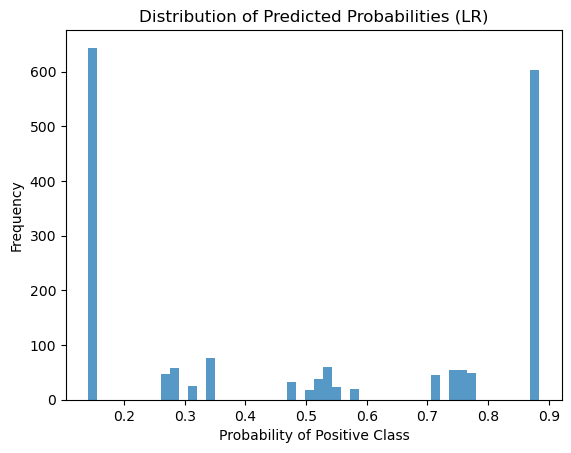

In [50]:
# Get probability scores for threshold optimization
svm_prob_scores = svm_meta_classifier.predict_proba(val_meta_features)[:, 1]

import matplotlib.pyplot as plt

# Plot the distribution of predicted probabilities
plt.hist(lr_prob_scores, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Probabilities (LR)')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()


In [51]:
adjusted_predictions = (svm_prob_scores >= svm_thresh).astype(int)

# Evaluate with the new threshold
adjusted_precision = precision_score(y_val, adjusted_predictions, average='binary')
adjusted_recall = recall_score(y_val, adjusted_predictions, average='binary')
adjusted_accuracy = accuracy_score(y_val, adjusted_predictions)
adjusted_f1 = f1_score(y_val, adjusted_predictions, average='binary')
adjusted_conf_matrix = confusion_matrix(y_val, adjusted_predictions)

print(f"Adjusted threshold: {svm_thresh}")
print("Optimized SVM")
print(f"Precision: {adjusted_precision}")
print(f"Recall: {adjusted_recall}")
print(f"Accuracy: {adjusted_accuracy}")
print(f"F1 Score: {adjusted_f1}")
print("Confusion Matrix:")
print(adjusted_conf_matrix)

Adjusted threshold: 0.23
Optimized SVM
Precision: 0.7614571092831962
Recall: 0.7534883720930232
Accuracy: 0.7753113156469952
F1 Score: 0.7574517825832846
Confusion Matrix:
[[784 203]
 [212 648]]


In [52]:
# SAVE TO GOOGLE SHEET

# Define the range and values to update
range_name = '4-1!F7:I7'  

values = [[
    f"{adjusted_precision * 100:.2f}",
    f"{adjusted_recall * 100:.2f}",
    f"{adjusted_accuracy * 100:.2f}",
    f"{adjusted_f1 * 100:.2f}"
]]

# Prepare the request body
body = {
    'values': values
}

# Call the Sheets API to update the values
result = service.spreadsheets().values().update(
    spreadsheetId=spreadsheet_id, 
    range=range_name,
    valueInputOption='USER_ENTERED',
    body=body
).execute()

print('Updated cells count:', result.get('updatedCells'))

Updated cells count: 4


#### Save CM

In [53]:
import altair as alt
import altair_saver
import pandas as pd
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_val, adjusted_predictions)

# Define class names
class_names = ['Non Hatespeech', 'Hate Speech']

# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names).reset_index().melt(id_vars='index')
cm_df.columns = ['True', 'Predicted', 'Count']

# Ensure the order of categories
cm_df['True'] = pd.Categorical(cm_df['True'], categories=class_names, ordered=True)
cm_df['Predicted'] = pd.Categorical(cm_df['Predicted'], categories=class_names, ordered=True)

# Create the Altair plot
heatmap = alt.Chart(cm_df).mark_rect().encode(
    x=alt.X('Predicted:O', sort=class_names),
    y=alt.Y('True:O', sort=class_names),
    color='Count:Q',
    tooltip=['True', 'Predicted', 'Count']
).properties(
    width=400,
    height=300,
    title='OH_Using_HS 4STK-1 LR'
)

# Add text labels
text = heatmap.mark_text(
    align='center',
    baseline='middle',
    fontSize=12
).encode(
    text='Count:Q',
    color=alt.condition(
        alt.datum.Count > cm.max() / 2,
        alt.value('white'),
        alt.value('black')
    )
)

# Combine heatmap and text
final_chart = heatmap + text

# Display the plot
final_chart.show()

alt.LayerChart(...)

In [54]:
# Specify the folder path
folder_path = os.path.expanduser('Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS Ensemble/Stacking/')

# Save the plot using vl-convert
file_path_png = os.path.join(folder_path, 'OH_Using_HS 4STK-1 SVM.png')
final_chart.save(file_path_png)

print(f"Plot saved to {file_path_png}")

Plot saved to Results/Ensemble Model Results/On Hatespeech dataset/OH Using HS Ensemble/Stacking/OH_Using_HS 4STK-1 SVM.png
